# Exploratory Data Analysis

In [350]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Data Overview and Cleaning
- Inspect Data: Get an overview of the dataset, check for missing values, data types, and unique values.
- Handle Missing Values: Address any missing values appropriately, possibly using imputation or removal based on the context.
- Clean Data: Remove or correct any anomalies or inconsistencies in the dataset (e.g., incorrect data types, typos).

In [349]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('gendered_data.csv')

# Get an overview of the dataset
print("Dataset Overview:")
print(df.head())
print()
# Additional dataset information
print('Data Set Info')
print(df.info())
print()
# Describe the dataset
print("\nDescribe Data Set")
print(df.describe(include='all'))
print()
# Check data types
print("\nData Types:")
print(df.dtypes)
print()
# Get unique values count for each column
print("\nUnique Values:")
print('Nunique: Counts number of distinct elements in specified axis. Returns Series with number of distinct elements')
print(df.nunique())
print()
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Overview:
   Unnamed: 0                  Job Title              Salary Estimate  \
0           0             Data Scientist   $53K-$91K (Glassdoor est.)   
1           1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2           2             Data Scientist   $80K-$90K (Glassdoor est.)   
3           3             Data Scientist   $56K-$97K (Glassdoor est.)   
4           4             Data Scientist  $86K-$143K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Data Scientist\nLocation: Albuquerque, NM\nEdu...     3.8   
1  What You Will Do:\n\nI. General Summary\n\nThe...     3.4   
2  KnowBe4, Inc. is a high growth information sec...     4.8   
3  *Organization and Job ID**\nJob ID: 310709\n\n...     3.8   
4  Data Scientist\nAffinity Solutions / Marketing...     2.9   

                                 Company Name         Location  \
0                      Tecolote Research\n3.8  Albuquerque, NM   
1  University of Maryland 

To predict gender bias in job descriptions, it's crucial to select features that are likely to be indicative of such bias. Based on the distributions and the nature of the data, the following features are most useful:

1. **Job Title**: Different job titles may carry varying degrees of gender bias. For instance, titles like "Data Scientist" vs. "Data Analyst" might have different gender associations.

2. **Job Description**: The actual text of the job description is crucial for detecting gendered language. This feature can be used for natural language processing (NLP) techniques to extract meaningful patterns.

3. **Agentic_Words and Communal_Words**: These features directly relate to gendered language. Agentic words are often associated with male stereotypes (e.g., "leader," "competitive"), while communal words are associated with female stereotypes (e.g., "support," "team").

4. **Rating**: Company ratings might reflect the overall company culture, which could influence the gender bias in job descriptions.

5. **Industry and Sector**: Certain industries and sectors might have different levels of gender bias based on historical and cultural factors.

6. **Size**: The size of the company could be indicative of its HR practices and policies regarding gender diversity and inclusion.

7. **Location**: Different geographical locations can have varying cultural attitudes towards gender, which might reflect in job descriptions.

8. **Job_simp and Seniority**: The simplified job role and seniority level can help in understanding how bias might vary across different job types and levels within the organization.

9. **Age of the Company (Founded)**: Older companies might have more entrenched biases compared to newer companies which might be more progressive.

10. **Agentic_Count and Communal_Count**: The counts of agentic and communal words in the job descriptions can provide a quantitative measure of the gendered language used.

Here is a summary of these features:

- **Textual Features**:
  - Job Title
  - Job Description
  - Agentic_Words
  - Communal_Words

- **Quantitative Features**:
  - Rating
  - Age (Founded)
  - Agentic_Count
  - Communal_Count

- **Categorical Features**:
  - Industry
  - Sector
  - Size
  - Location
  - Job_simp
  - Seniority

Using these features, you can build a model that combines NLP techniques for analyzing the textual data with traditional machine learning methods for the categorical and quantitative data. This hybrid approach can help capture both the explicit and subtle indicators of gender bias in job descriptions.

### Data Preprocessing
#### Textual Data:
1. Tokenization: Split the job descriptions and other text features into words or tokens.
1. Stop Words Removal: Remove common words that do not contribute much meaning (e.g., "and", "the").
1. Lemmatization/Stemming: Reduce words to their base or root form (e.g., "running" to "run").
1. Vectorization: Convert text data into numerical format using methods like TF-IDF or Word Embeddings (e.g., Word2Vec, GloVe).
#### Categorical and Numerical Data:
1. Handling Missing Values: Fill or remove missing values.
1. Encoding Categorical Features: Convert categorical variables into numerical format using one-hot encoding or label encoding.
1. Feature Scaling: Normalize or standardize numerical features to ensure they have similar scales.

In [357]:
# Define features and target
text_features = ['Job Description', 'Agentic_Words', 'Communal_Words']
categorical_features = ['Job Title', 'Industry', 'Sector', 'Size', 'Location', 'Job_simp', 'Seniority']
numerical_features = ['Rating', 'Founded', 'Agentic_Count', 'Communal_Count']
# Check if the columns exist in the DataFrame

missing_columns = [col for col in categorical_features + numerical_features if col not in df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    # Preprocessing for text data
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(stop_words='english'))
    ])

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', text_transformer, text_features[0]),
            ('agentic_text', text_transformer, text_features[1]),
            ('communal_text', text_transformer, text_features[2]),
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Define the model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ])

    # Split data
    X = df[text_features + categorical_features + numerical_features]
    y = df['target']  # Replace 'target' with the actual target column name
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
 



Missing columns: ['Job_simp', 'Seniority']


### Feature Engineering
1. Extract Features from Text:
    - TF-IDF vectors of job descriptions, agentic words, and communal words.
    - Count of agentic and communal words.
2. Combine Features: Create a single feature matrix combining the numerical representations of textual data and other categorical/numerical features.

In [355]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'Job Description'),
        ('agentic_text', text_transformer, 'Agentic_Words'),
        ('communal_text', text_transformer, 'Communal_Words'),
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Model Building
Split the Data: Divide the dataset into training and testing sets.
Model Selection: Choose a model suitable for the task. For this problem, models like Logistic Regression, Random Forest, Gradient Boosting, or even Neural Networks could be used.
Model Training: Train the model on the training set.
Model Evaluation: Evaluate the model on the testing set using metrics such as accuracy, precision, recall, F1-score, and AUC-ROC.
### Pipeline Creation
Create a pipeline to streamline the preprocessing and modeling steps. This ensures that all steps are applied consistently during training and testing.

In [356]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Split data
X = df[text_features + categorical_features + numerical_features]
y = df['target']  # Replace 'target' with the actual target column name
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

KeyError: "['Job_simp', 'Seniority'] not in index"

In [246]:
# Value Counts: Check the distribution of categorical variables
print('Categorical Varialbes: "job_simp"')
print(df['job_simp'].value_counts())
print()
print()
print('Categorical Varialbes: "Industry"')
print(df['Industry'].value_counts())

Categorical Varialbes: "Job Title"
Job Title
Data Scientist                     131
Data Engineer                       53
Senior Data Scientist               34
Data Analyst                        15
Senior Data Engineer                14
                                  ... 
Data Scientist/ML Engineer           1
Sr. Data Scientist                   1
Data Engineer 4 - Contract           1
Data Analyst - Asset Management      1
Machine Learning Engineer (NLP)      1
Name: count, Length: 264, dtype: int64


Categorical Varialbes: "Industry"
Industry
Biotech & Pharmaceuticals                   112
Insurance Carriers                           63
Computer Hardware & Software                 59
IT Services                                  50
Health Care Services & Hospitals             49
Enterprise Software & Network Solutions      42
Internet                                     29
Consulting                                   29
Aerospace & Defense                          25
Advertisin

## Exploratory Visualizations

<Axes: >

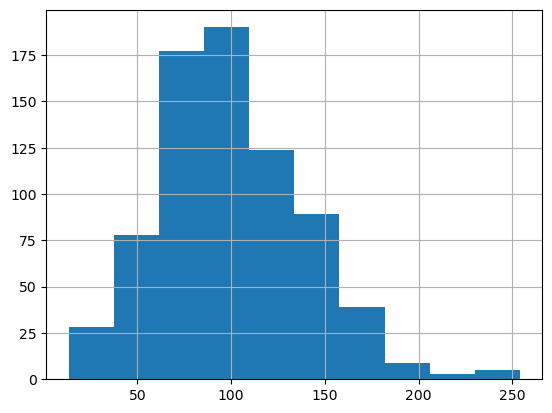

In [247]:
# Histograms and Boxplots: Visualize the distribution of numeric features like salary, rating, and description length.
df['avg_salary'].hist()


<Axes: >

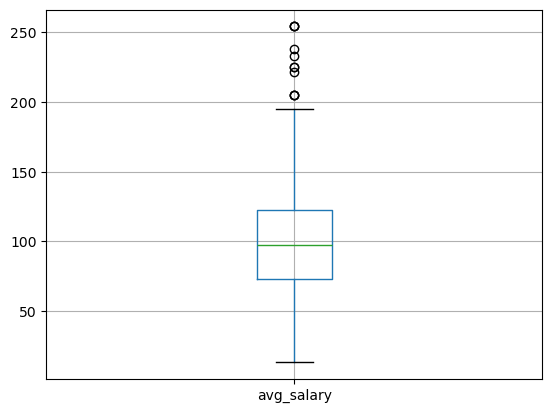

In [248]:
df.boxplot(column=['avg_salary'])

<Axes: >

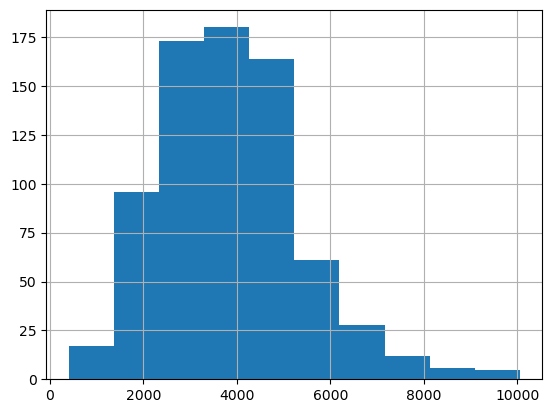

In [249]:
#  Job description length 
df['desc_len'].hist()

In [250]:
# Ensure all entries are strings, replacing NaN with an empty string
df['Agentic_Words'] = df['Agentic_Words'].fillna('').astype(str)
df['Communal_Words'] = df['Communal_Words'].fillna('').astype(str)

agentic_counter = Counter(' '.join(df['Agentic_Words']).split())
communal_counter = Counter(' '.join(df['Communal_Words']).split())

print(agentic_counter.most_common(10))
print(communal_counter.most_common(10))

[('Strong', 485), ('strong', 332), ('internal', 330), ('scientific', 319), ('innovative', 282), ('external', 279), ('quantitative', 254), ('high', 239), ('leadership', 233), ('equal', 233)]
[('team', 2148), ('support', 787), ('understanding', 382), ('partner', 320), ('patient', 229), ('collaborative', 170), ('community', 163), ('cross-functional', 129), ('Collaborate', 127), ('family', 110)]


<Axes: xlabel='Industry'>

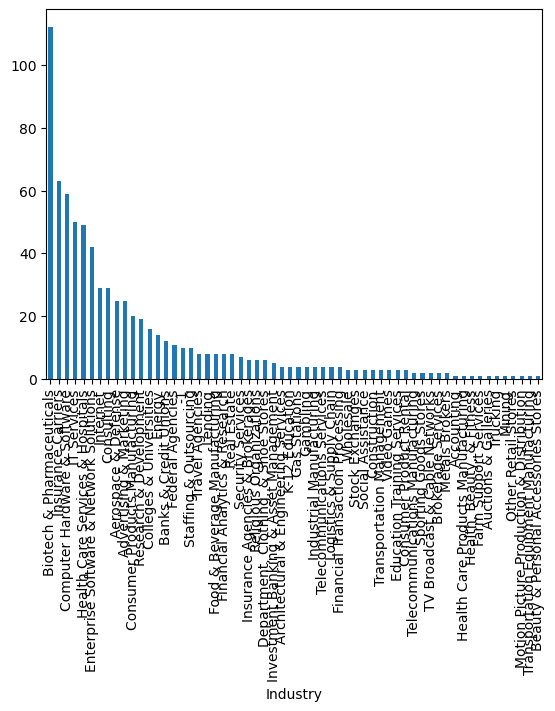

In [251]:
#Bar Plots: Visualize the counts of different job titles, industries, and other categorical variables.
df['Industry'].value_counts().plot(kind='bar')

<Axes: xlabel='job_state'>

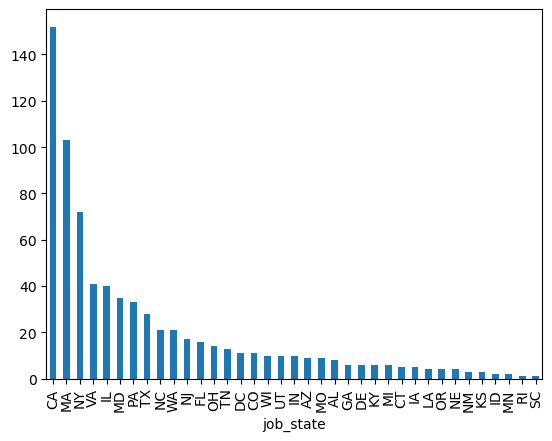

In [252]:
df['job_state'].value_counts().plot(kind='bar')

<Axes: xlabel='Agentic_Count'>

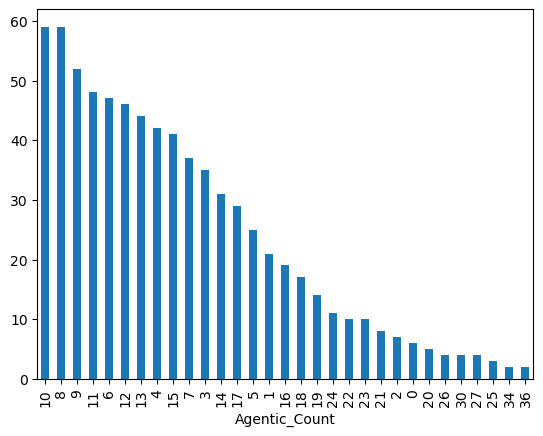

In [253]:
df['Agentic_Count'].value_counts().plot(kind='bar')

<Axes: xlabel='Communal_Count'>

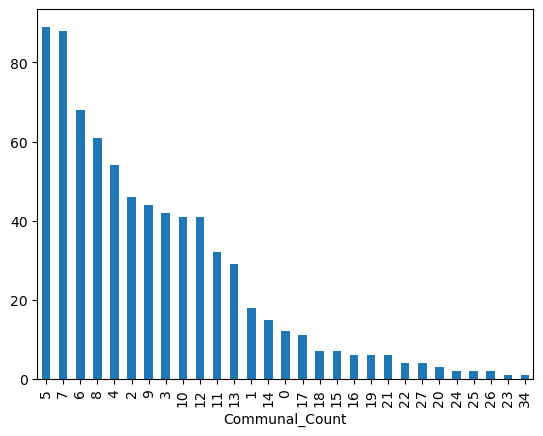

In [254]:
df['Communal_Count'].value_counts().plot(kind='bar')

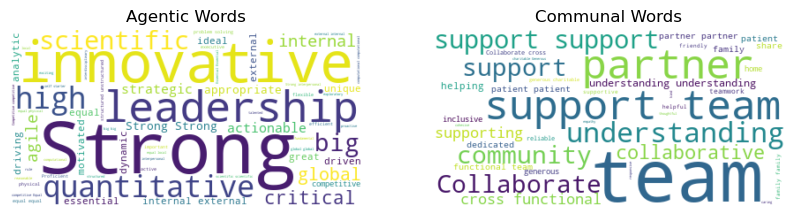

In [255]:
# Word Clouds: Create word clouds for agentic and communal words to visualize common terms
agentic_text = ' '.join(df['Agentic_Words'])
communal_text = ' '.join(df['Communal_Words'])

agentic_wc = WordCloud(background_color='white').generate(agentic_text)
communal_wc = WordCloud(background_color='white').generate(communal_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(agentic_wc, interpolation='bilinear')
plt.title('Agentic Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(communal_wc, interpolation='bilinear')
plt.title('Communal Words')
plt.axis('off')

plt.show()

## Correlation Analysis

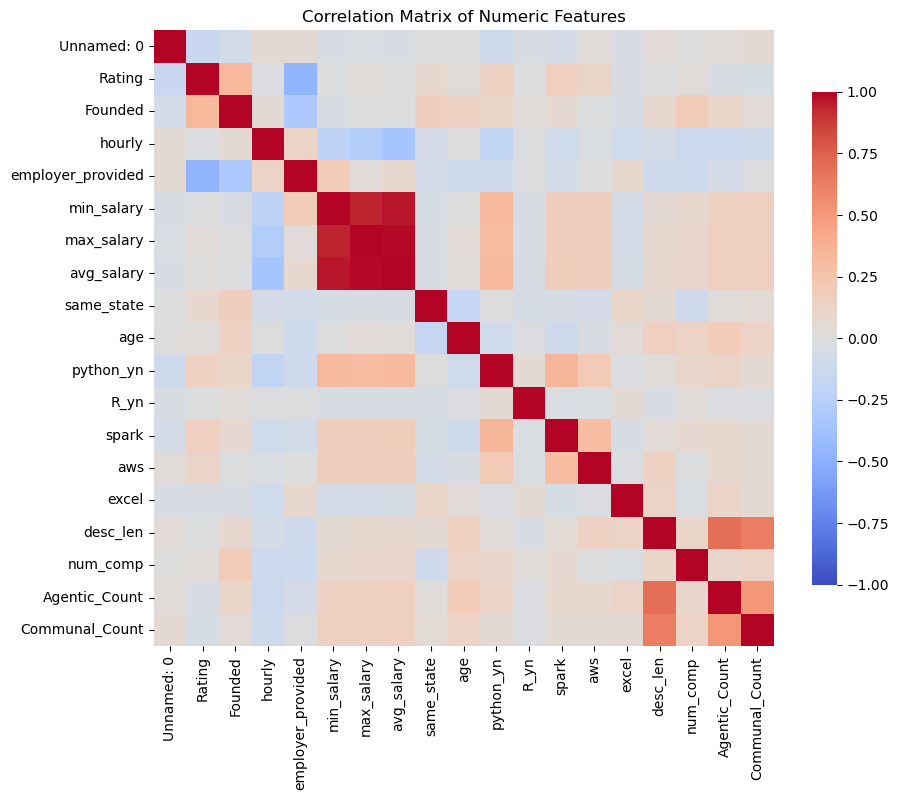

In [256]:
# Correlation Matrix: Compute and visualize the correlation matrix for numeric features.
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute and visualize the correlation matrix for numeric features
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix of Numeric Features')
plt.show()

To show the results of the correlation matrix as a table from most correlated to least, you can follow these steps:

Compute the correlation matrix: This step you've already done with numeric_df.corr().

Unstack the matrix: Convert the matrix into a Series of correlation values.

Sort the values: Sort the Series to find the most correlated pairs.

Format the output: Present the sorted correlations in a readable table format.

In [257]:
# Assuming `numeric_df` is your DataFrame with numeric features
corr_matrix = numeric_df.corr()

# Unstack the matrix and remove self-correlation (diagonal elements)
corr_series = corr_matrix.unstack()
corr_series = corr_series[corr_series != 1]  # Remove self-correlation

# Sort the series
sorted_corr = corr_series.sort_values(ascending=False)

# Create a DataFrame for better readability
corr_table = pd.DataFrame(sorted_corr, columns=['Correlation'])
corr_table.reset_index(inplace=True)
corr_table.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Display the table
print(corr_table.head(60))
print(df.info())

            Feature 1          Feature 2  Correlation
0          max_salary         avg_salary     0.986862
1          avg_salary         max_salary     0.986862
2          avg_salary         min_salary     0.967765
3          min_salary         avg_salary     0.967765
4          max_salary         min_salary     0.940136
5          min_salary         max_salary     0.940136
6            desc_len      Agentic_Count     0.692643
7       Agentic_Count           desc_len     0.692643
8      Communal_Count           desc_len     0.632605
9            desc_len     Communal_Count     0.632605
10      Agentic_Count     Communal_Count     0.513213
11     Communal_Count      Agentic_Count     0.513213
12              spark          python_yn     0.347619
13          python_yn              spark     0.347619
14            Founded             Rating     0.332927
15             Rating            Founded     0.332927
16          python_yn         avg_salary     0.327796
17         avg_salary       

## Text Analysis

In [258]:
# Text Length Analysis: Analyze the length of job descriptions
df['desc_len'].describe()

count      742.000000
mean      3869.545822
std       1521.495868
min        407.000000
25%       2801.000000
50%       3731.000000
75%       4740.000000
max      10051.000000
Name: desc_len, dtype: float64

In [259]:
# Word Frequency: Calculate the frequency of agentic and communal words
agentic_counter = Counter(' '.join(df['Agentic_Words']).split())
communal_counter = Counter(' '.join(df['Communal_Words']).split())

print(agentic_counter.most_common(10))
print(communal_counter.most_common(10))

[('Strong', 485), ('strong', 332), ('internal', 330), ('scientific', 319), ('innovative', 282), ('external', 279), ('quantitative', 254), ('high', 239), ('leadership', 233), ('equal', 233)]
[('team', 2148), ('support', 787), ('understanding', 382), ('partner', 320), ('patient', 229), ('collaborative', 170), ('community', 163), ('cross-functional', 129), ('Collaborate', 127), ('family', 110)]


## Gendered Language Patterns

array([[<Axes: title={'center': 'Agentic_Count'}>,
        <Axes: title={'center': 'Communal_Count'}>]], dtype=object)

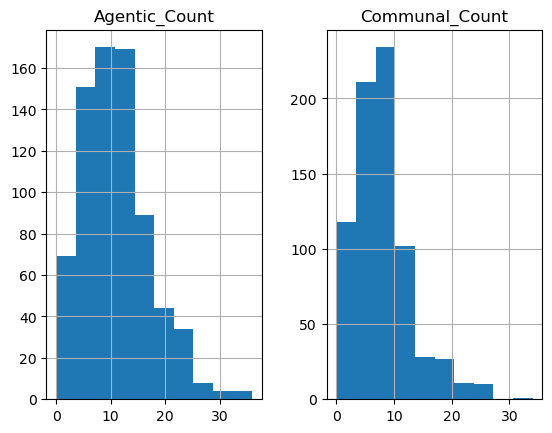

In [260]:
# Agentic vs Communal Word Counts: Compare the count of agentic and communal words across job descriptions.
df[['Agentic_Count', 'Communal_Count']].describe()
df[['Agentic_Count', 'Communal_Count']].hist()


In [261]:
# Top Job Titles by Gendered Language: Identify job titles with the highest and lowest counts of agentic and communal words.
agentic_top_titles = df.groupby('Job Title')['Agentic_Count'].sum().sort_values(ascending=False)
communal_top_titles = df.groupby('Job Title')['Communal_Count'].sum().sort_values(ascending=False)

print(agentic_top_titles.head(10))
print(communal_top_titles.head(10))



Job Title
Data Scientist                               1339
Data Engineer                                 512
Senior Data Scientist                         416
Senior Data Engineer                          161
Data Analyst                                  157
Senior Data Analyst                           143
Lead Data Scientist                           137
Managing Data Scientist/ML Engineer            72
Senior Scientist - Regulatory Submissions      72
Senior Insurance Data Scientist                69
Name: Agentic_Count, dtype: int64
Job Title
Data Scientist                                                                           909
Data Engineer                                                                            402
Senior Data Scientist                                                                    238
Senior Data Analyst                                                                      143
Senior Data Engineer                                                      

## Feature Engineering

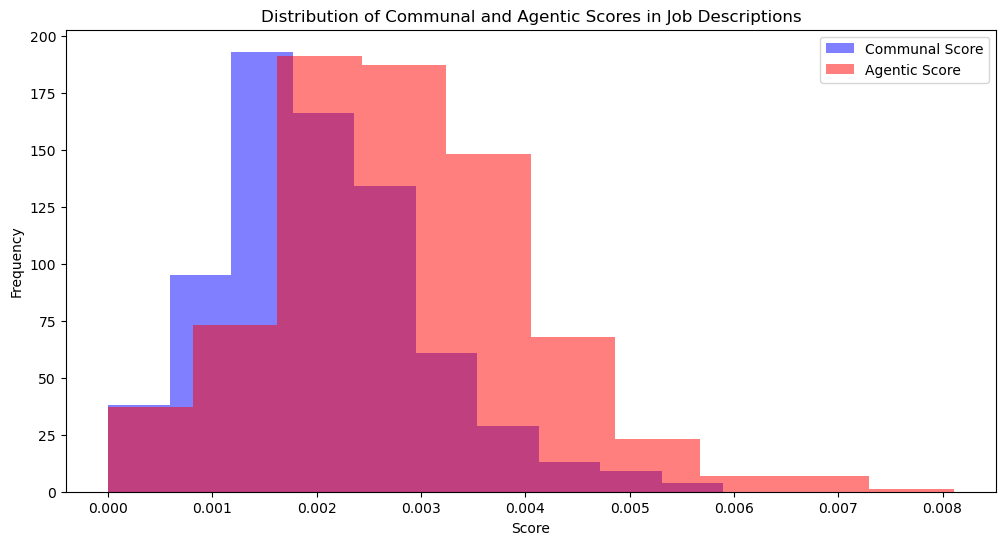

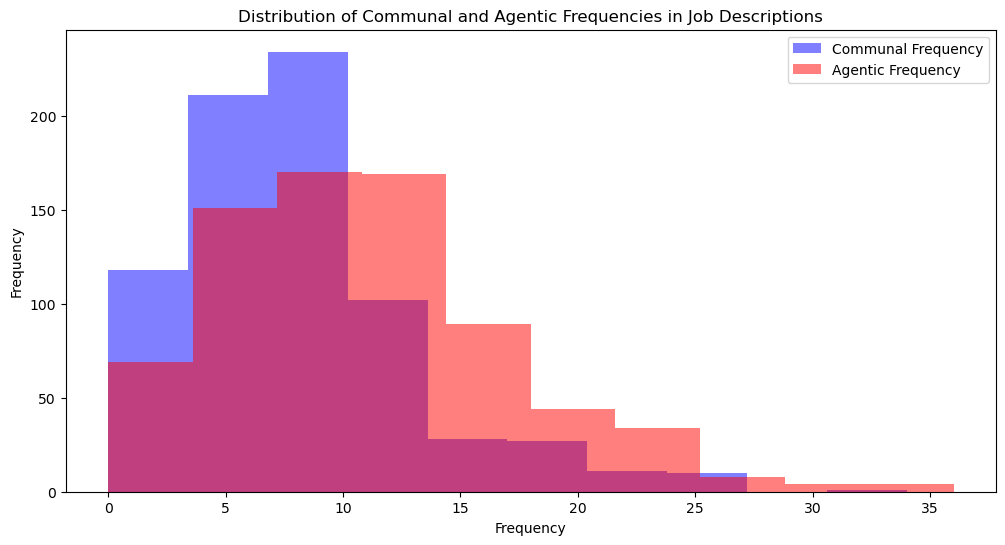

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 742 non-null    int64  
 1   Job Title                  742 non-null    object 
 2   Salary Estimate            742 non-null    object 
 3   Job Description            742 non-null    object 
 4   Rating                     742 non-null    float64
 5   Company Name               742 non-null    object 
 6   Location                   742 non-null    object 
 7   Headquarters               742 non-null    object 
 8   Size                       742 non-null    object 
 9   Founded                    742 non-null    int64  
 10  Type of ownership          742 non-null    object 
 11  Industry                   742 non-null    object 
 12  Sector                     742 non-null    object 
 13  Revenue                    742 non-null    object 

In [262]:
# Example: Normalizing by the description length
df['communal_score_normalized'] = df['Communal_Count'] / df['desc_len']
df['agentic_score_normalized'] = df['Agentic_Count'] / df['desc_len']


plt.figure(figsize=(12, 6))
df['communal_score_normalized'].plot(kind='hist', alpha=0.5, label='Communal Score', color='blue')
df['agentic_score_normalized'].plot(kind='hist', alpha=0.5, label='Agentic Score', color='red')
plt.legend()
plt.xlabel('Score')
plt.title('Distribution of Communal and Agentic Scores in Job Descriptions')
plt.show()

plt.figure(figsize=(12, 6))
df['Communal_Count'].plot(kind='hist', alpha=0.5, label='Communal Frequency', color='blue')
df['Agentic_Count'].plot(kind='hist', alpha=0.5, label='Agentic Frequency', color='red')
plt.legend()
plt.xlabel('Frequency')
plt.title('Distribution of Communal and Agentic Frequencies in Job Descriptions')
plt.show()

print(df.info())


In [263]:
# Create New Features: Develop new features that might help in modeling, such as ratios of agentic to communal words, or binary indicators for presence of certain keywords.
df['agentic_to_communal_ratio'] = df['Agentic_Count'] / (df['Communal_Count'] + 1)
df['has_agentic_words'] = df['Agentic_Count'] > 0
df['has_communal_words'] = df['Communal_Count'] > 0

# Text Length Analysis: Analyze the length of job descriptions
df['agentic_to_communal_ratio'].describe()



count    742.000000
mean       1.475845
std        1.113377
min        0.000000
25%        0.833333
50%        1.250000
75%        1.800000
max       10.000000
Name: agentic_to_communal_ratio, dtype: float64

                        agentic_communal_ratio  desc_len       age  \
agentic_communal_ratio                1.000000 -0.001278  0.011775   
desc_len                             -0.001278  1.000000  0.163911   
age                                   0.011775  0.163911  1.000000   
avg_salary                           -0.002072  0.078808  0.019655   
Rating                               -0.001470 -0.012281  0.021655   
Founded                               0.052769  0.083119  0.134682   
same_state                            0.056185  0.062387 -0.166680   
num_comp                             -0.026039  0.104620  0.126687   
job_simp_encoded                     -0.113105 -0.067297 -0.027740   
seniority_encoded                    -0.065601  0.109600 -0.001431   
location_encoded                     -0.113493 -0.006841  0.012541   
company_size_encoded                  0.046715 -0.057843 -0.064982   
ownership_encoded                    -0.038853  0.140883  0.148453   
industry_encoded    

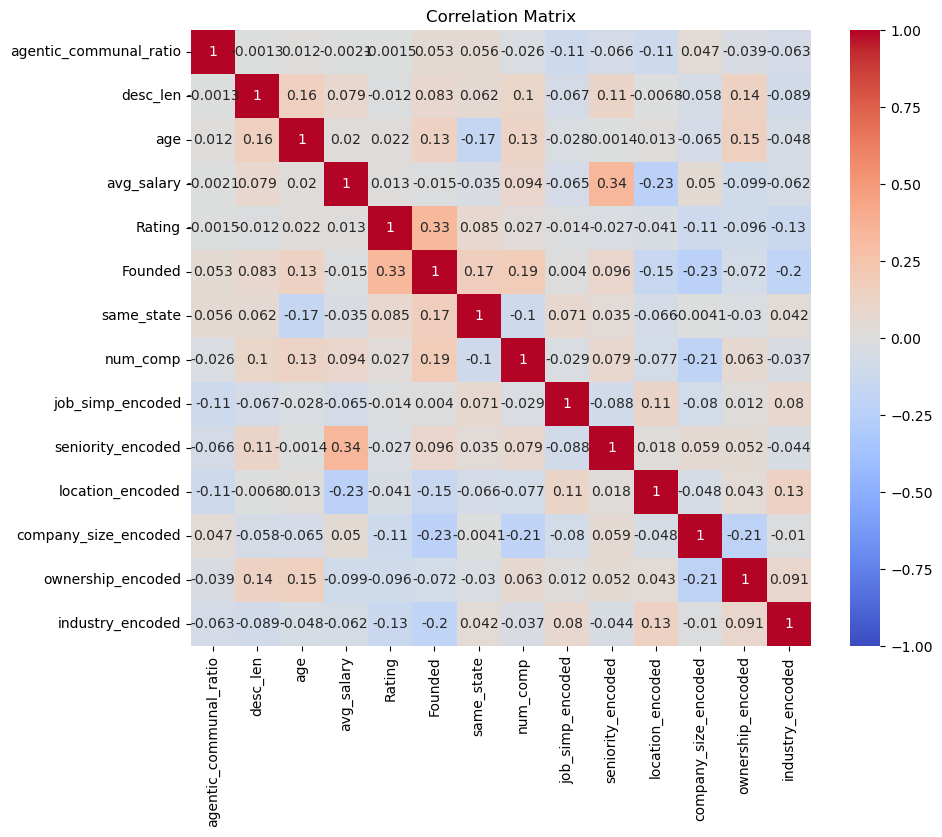

In [ ]:
# Calculate the agentic to communal ratio and ensure it is added to the DataFrame
df['agentic_communal_ratio'] = df['Agentic_Count'] / (df['Communal_Count'] + 1)

# Convert categorical features to numerical data types
# Example: Encode 'job_simp' and 'seniority' as categorical variables
df['job_simp_encoded'] = pd.factorize(df['job_simp'])[0]
df['seniority_encoded'] = pd.factorize(df['seniority'])[0]
df['location_encoded'] = pd.factorize(df['Location'])[0]
df['company_size_encoded'] = pd.factorize(df['Size'])[0]
df['ownership_encoded'] = pd.factorize(df['Type of ownership'])[0]
df['industry_encoded'] = pd.factorize(df['Industry'])[0]

# Select relevant features for correlation analysis
features = [
    'agentic_communal_ratio', 'desc_len', 'age', 'avg_salary', 'Rating', 
    'Founded', 'same_state', 'num_comp', 'job_simp_encoded', 'seniority_encoded',
    'location_encoded', 'company_size_encoded', 'ownership_encoded', 'industry_encoded',
]
# Create a DataFrame with the selected features
correlation_df = df[features]

# Compute the correlation matrix
corr_matrix = correlation_df.corr()

print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

                        agentic_communal_ratio  desc_len       age  \
agentic_communal_ratio                1.000000 -0.001278  0.011775   
desc_len                             -0.001278  1.000000  0.163911   
age                                   0.011775  0.163911  1.000000   
avg_salary                           -0.002072  0.078808  0.019655   
Rating                               -0.001470 -0.012281  0.021655   
Founded                               0.052769  0.083119  0.134682   
same_state                            0.056185  0.062387 -0.166680   
num_comp                             -0.026039  0.104620  0.126687   
job_simp_encoded                     -0.113105 -0.067297 -0.027740   
seniority_encoded                    -0.065601  0.109600 -0.001431   
location_encoded                     -0.113493 -0.006841  0.012541   
company_size_encoded                  0.046715 -0.057843 -0.064982   
ownership_encoded                    -0.038853  0.140883  0.148453   
industry_encoded    

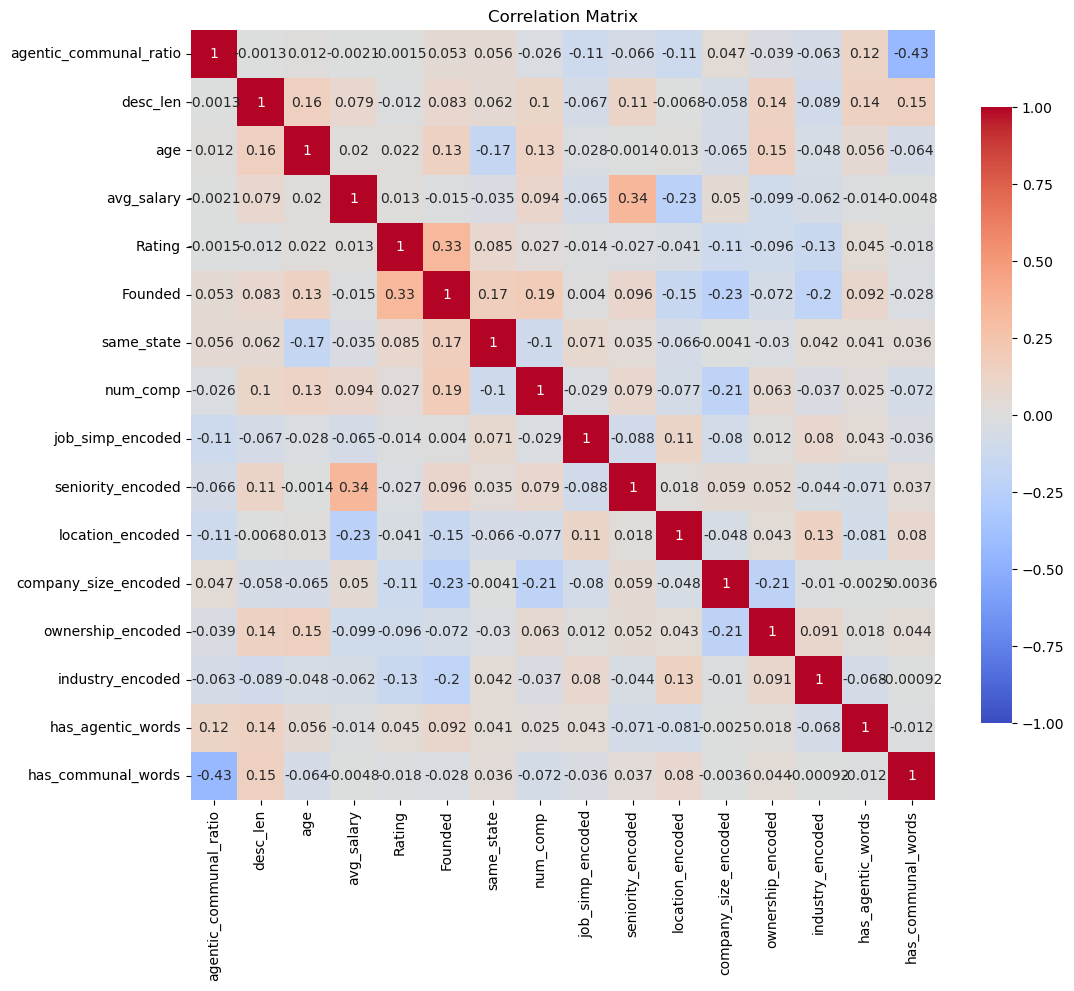

In [ ]:

# Create new features
df['agentic_to_communal_ratio'] = df['Agentic_Count'] / (df['Communal_Count'] + 1)
df['has_agentic_words'] = df['Agentic_Count'] > 0
df['has_communal_words'] = df['Communal_Count'] > 0

# Convert categorical features to numerical data types
df['job_simp_encoded'] = pd.factorize(df['job_simp'])[0]
df['seniority_encoded'] = pd.factorize(df['seniority'])[0]
df['location_encoded'] = pd.factorize(df['Location'])[0]
df['company_size_encoded'] = pd.factorize(df['Size'])[0]
df['ownership_encoded'] = pd.factorize(df['Type of ownership'])[0]
df['industry_encoded'] = pd.factorize(df['Industry'])[0]

# Select relevant features for correlation analysis
features = [
    'agentic_communal_ratio', 'desc_len', 'age', 'avg_salary', 'Rating', 
    'Founded', 'same_state', 'num_comp', 'job_simp_encoded', 'seniority_encoded',
    'location_encoded', 'company_size_encoded', 'ownership_encoded', 'industry_encoded',
    'has_agentic_words', 'has_communal_words'
]

# Create a DataFrame with the selected features
correlation_df = df[features]

# Compute the correlation matrix
corr_matrix = correlation_df.corr()

# Display the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix')
plt.show()


In [ ]:


# Create new features if not already created
df['agentic_to_communal_ratio'] = df['Agentic_Count'] / (df['Communal_Count'] + 1)
df['has_agentic_words'] = df['Agentic_Count'] > 0
df['has_communal_words'] = df['Communal_Count'] > 0

# Convert categorical features to numerical data types
df['job_simp_encoded'] = pd.factorize(df['job_simp'])[0]
df['seniority_encoded'] = pd.factorize(df['seniority'])[0]
df['location_encoded'] = pd.factorize(df['Location'])[0]
df['company_size_encoded'] = pd.factorize(df['Size'])[0]
df['ownership_encoded'] = pd.factorize(df['Type of ownership'])[0]
df['industry_encoded'] = pd.factorize(df['Industry'])[0]

# Select only numeric columns for correlation analysis
numeric_features = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numeric_features.corr()

# Extract the correlation of 'agentic_to_communal_ratio' with all other features
agentic_to_communal_corr = corr_matrix['agentic_to_communal_ratio']

# Sort the correlations from most to least correlated
sorted_corr = agentic_to_communal_corr.sort_values(ascending=False)

# Display the sorted correlations
print(sorted_corr)


agentic_communal_ratio       1.000000
agentic_to_communal_ratio    1.000000
Gender_Bias_Label            0.602144
agentic_score_normalized     0.525729
Agentic_Count                0.322964
same_state                   0.056185
Founded                      0.052769
company_size_encoded         0.046715
excel                        0.038130
python_yn                    0.026797
age                          0.011775
R_yn                         0.008916
aws                          0.002205
desc_len                    -0.001278
Rating                      -0.001470
avg_salary                  -0.002072
max_salary                  -0.003845
min_salary                  -0.014431
num_comp                    -0.026039
ownership_encoded           -0.038853
Unnamed: 0                  -0.048125
hourly                      -0.048713
spark                       -0.049481
industry_encoded            -0.062608
employer_provided           -0.065092
seniority_encoded           -0.065601
job_simp_enc

. Understand the Data Distribution
Plot Distribution:

Plot histograms or density plots of the feature (agentic_to_communal_ratio in this case) to understand its distribution.
This will help you visualize where the data is concentrated and identify potential cutoff points.

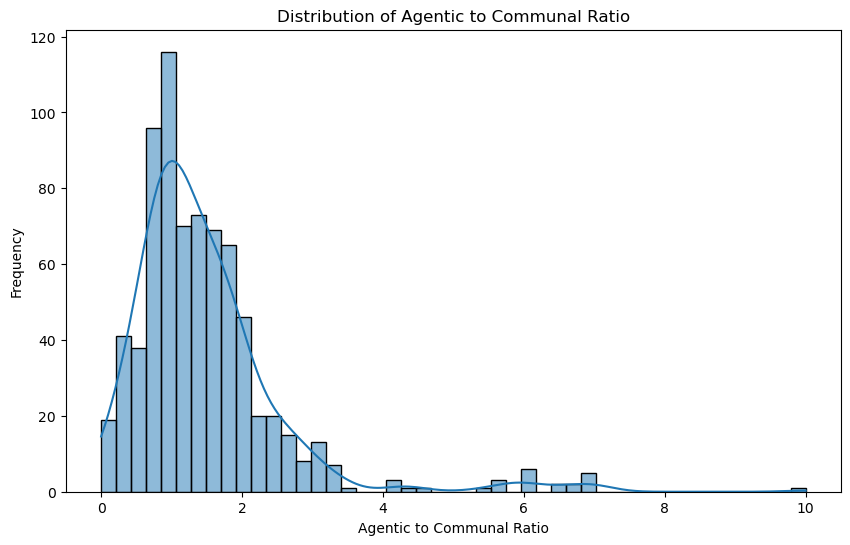

In [ ]:
# Plot histogram of agentic_to_communal_ratio
plt.figure(figsize=(10, 6))
sns.histplot(df['agentic_to_communal_ratio'], kde=True)
plt.title('Distribution of Agentic to Communal Ratio')
plt.xlabel('Agentic to Communal Ratio')
plt.ylabel('Frequency')
plt.show()

In [ ]:
threshold = 1.5  # Adjust based on your analysis
df['Gender_Bias_Label'] = (df['agentic_to_communal_ratio'] > threshold).astype(int)

# Verify the column creation
print(df['Gender_Bias_Label'].head())


0    1
1    1
2    1
3    0
4    0
Name: Gender_Bias_Label, dtype: int64


In [ ]:
# Compute the correlation with the new column
corr_with_bias = df['agentic_to_communal_ratio'].corr(df['Gender_Bias_Label'])
print(f'Correlation with Gender Bias Label: {corr_with_bias}')


Correlation with Gender Bias Label: 0.6701609066355982


## Exploring agentic_to_communal_ratio Correlation Gender_Bias_Label
If you have other indicators of gender bias, examine their correlation with agentic_to_communal_ratio. This can provide insights into how different values of the ratio align with bias.

In [ ]:
# Compute correlation with Gender_Bias_Label
corr_with_bias = df['agentic_to_communal_ratio'].corr(df['Gender_Bias_Label'])
print(f'Correlation with Gender Bias Label: {corr_with_bias}')


Correlation with Gender Bias Label: 0.6701609066355982


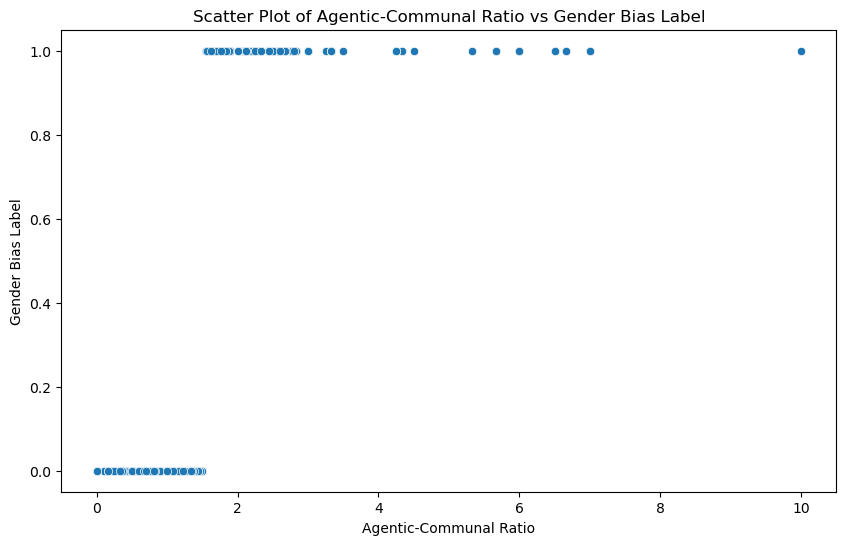

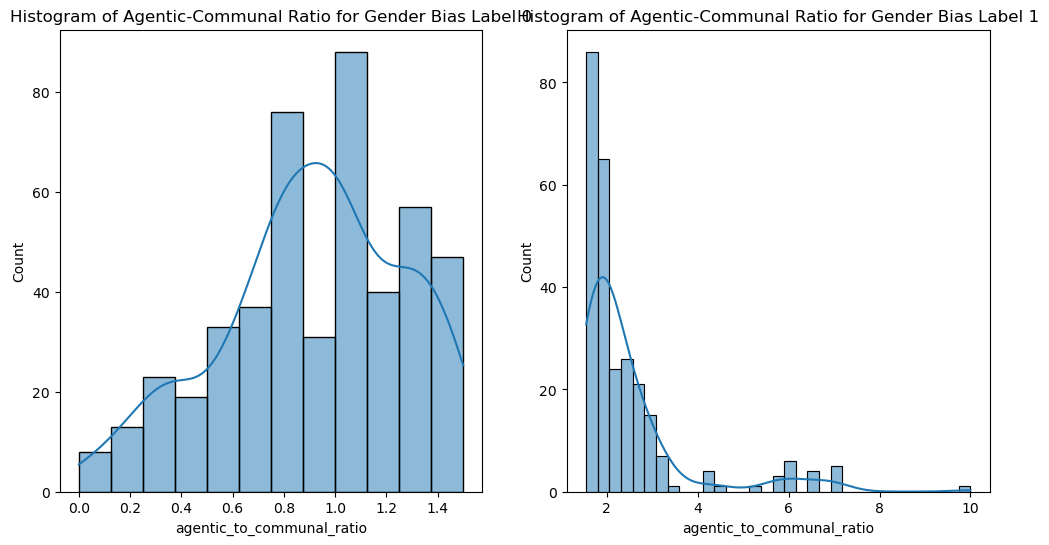

In [ ]:
df['agentic_to_communal_ratio'] = pd.to_numeric(df['agentic_to_communal_ratio'], errors='coerce')
df['Gender_Bias_Label'] = pd.to_numeric(df['Gender_Bias_Label'], errors='coerce')

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='agentic_to_communal_ratio', y='Gender_Bias_Label')
plt.title('Scatter Plot of Agentic-Communal Ratio vs Gender Bias Label')
plt.xlabel('Agentic-Communal Ratio')
plt.ylabel('Gender Bias Label')
plt.show()

# Histograms
plt.figure(figsize=(12, 6))

# Histogram for Gender Bias Label 0
plt.subplot(1, 2, 1)
sns.histplot(df[df['Gender_Bias_Label'] == 0]['agentic_to_communal_ratio'], kde=True)
plt.title('Histogram of Agentic-Communal Ratio for Gender Bias Label 0')

# Histogram for Gender Bias Label 1
plt.subplot(1, 2, 2)
sns.histplot(df[df['Gender_Bias_Label'] == 1]['agentic_to_communal_ratio'], kde=True)
plt.title('Histogram of Agentic-Communal Ratio for Gender Bias Label 1')

plt.show()



### Statistical Analysis
Regression Analysis

In [ ]:
import statsmodels.api as sm

# Prepare the data for regression
X = df[['agentic_to_communal_ratio']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = df['Gender_Bias_Label']

# Fit the model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary
print(result.summary())


         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:      Gender_Bias_Label   No. Observations:                  742
Model:                          Logit   Df Residuals:                      740
Method:                           MLE   Df Model:                            1
Date:                Fri, 19 Jul 2024   Pseudo R-squ.:                   1.000
Time:                        11:48:06   Log-Likelihood:            -6.4389e-05
converged:                      False   LL-Null:                       -486.47
Covariance Type:            nonrobust   LLR p-value:                1.370e-213
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -829.5225   8340.680     -0.099      0.921   -1.72e+04    1.55e+04
agentic_to_communal_

/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Check Data Balance:
Verify if your Gender_Bias_Label has a balanced distribution. If it’s highly imbalanced, it could lead to complete separation.

In [ ]:
print(df['Gender_Bias_Label'].value_counts())

Gender_Bias_Label
0    472
1    270
Name: count, dtype: int64


Data Imbalance detected: Your data is imbalanced, with more instances of class 0 compared to class 1. This imbalance can lead to perfect separation, which is problematic for logistic regression

When dealing with imbalanced data, you can consider:

Resampling: Use oversampling for the minority class or undersampling for the majority class.
Adjust Class Weights: Modify the class weights in your model to handle imbalances.

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

# Convert classes to numpy array
classes = np.array([0, 1])

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))

# Initialize and fit the model with class weights
model = LogisticRegression(penalty='l2', solver='liblinear', class_weight=class_weight_dict)
model.fit(X, y)

# Print coefficients and intercept
print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)



Coefficient: [[ 3.83620187e+00 -8.52875585e-03  5.17371158e-02  3.36403531e-04
  -3.96182027e-03 -2.13632114e-01 -3.10363664e-04  2.61360953e-01
   1.24612119e-02 -3.07220063e-02  1.66019675e-02  7.70809674e-03
  -2.22828634e-01 -3.90958961e-02 -8.21930778e-01 -7.47499210e-02
  -4.91681714e-02 -4.06563729e-05 -2.98081526e-04 -1.68223551e-01
  -1.80907916e+00 -1.51466620e+00]]
Intercept: [-1.91035756]


Interpretation
- Coefficients: These represent the change in the log odds of the dependent variable (gender bias) for a one-unit change in each predictor. Positive values increase the log odds, while negative values decrease it.
- Intercept: The log odds of the dependent variable when all predictors are zero.

In [ ]:
import numpy as np

# Coefficients from the model
coefficients = np.array([3.83620187, -0.00852875585, 0.0517371158, 0.000336403531, -0.00396182027, -0.213632114, -0.000310363664, 0.261360953, 0.0124612119, -0.0307220063, 0.0166019675, 0.00770809674, -0.222828634, -0.0390958961, -0.821930778, -0.0747499210, -0.0491681714, -0.0000406563729, -0.000298081526, -0.168223551, -1.80907916, -1.51466620])
intercept = -1.91035756

# Calculate odds ratios
odds_ratios = np.exp(coefficients)
intercept_or = np.exp(intercept)

# Print results
print("Odds Ratios for Coefficients:")
print(odds_ratios)
print("Odds Ratio for Intercept:")
print(intercept_or)


Odds Ratios for Coefficients:
[46.3490998   0.99150751  1.05309886  1.00033646  0.99604602  0.80764545
  0.99968968  1.29869635  1.01253918  0.96974512  1.01674055  1.00773788
  0.80025197  0.96165849  0.4395821   0.92797552  0.95202101  0.99995934
  0.99970196  0.84516488  0.16380491  0.21988157]
Odds Ratio for Intercept:
0.1480274484372793


High Odds Ratios: Values significantly greater than 1 (e.g., 46.35, 1.30) indicate a strong positive association with the outcome.
Low Odds Ratios: Values significantly less than 1 (e.g., 0.16, 0.22) indicate a strong negative association with the outcome.
Odds Ratios Near 1: Values close to 1 (e.g., 1.01, 0.99) suggest minimal effect on the odds.

Use Regularization:
Logistic regression models can benefit from regularization, which can help when facing issues like complete separation. Consider using sklearn's LogisticRegression with regularization:

In [ ]:
model = LogisticRegression(penalty='l2', solver='liblinear')
model.fit(X, y)
print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)

Coefficient: [[ 3.84020175e+00 -8.30270102e-03  6.90962171e-02 -2.53160223e-02
  -4.52298575e-03 -2.24401532e-01 -2.91717690e-04  2.52701449e-01
   4.54502699e-02 -2.85531997e-02  1.93207865e-02  2.99593610e-03
  -2.49378420e-01 -2.28077827e-02 -8.39381702e-01 -7.38817034e-02
  -4.03308854e-02 -2.89767041e-05 -6.93129462e-04 -1.54790540e-01
  -1.96727689e+00 -1.62923192e+00]]
Intercept: [-2.05903709]


Check for Multicollinearity:
Ensure there is no multicollinearity among the predictors. In your case, you have only one predictor, but it's good practice to check if there are other predictors causing issues.

### Use Regularization:
Logistic regression models can benefit from regularization, which can help when facing issues like complete separation. Consider using sklearn's LogisticRegression with regularization:

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', solver='liblinear')
model.fit(X, y)
print("Coefficient:", model.coef_)
print("Intercept:", model.intercept_)

Coefficient: [[ 3.84020175e+00 -8.30270102e-03  6.90962171e-02 -2.53160223e-02
  -4.52298575e-03 -2.24401532e-01 -2.91717690e-04  2.52701449e-01
   4.54502699e-02 -2.85531997e-02  1.93207865e-02  2.99593610e-03
  -2.49378420e-01 -2.28077827e-02 -8.39381702e-01 -7.38817034e-02
  -4.03308854e-02 -2.89767041e-05 -6.93129462e-04 -1.54790540e-01
  -1.96727689e+00 -1.62923192e+00]]
Intercept: [-2.05903709]


### Check for Multicollinearity:
Ensure there is no multicollinearity among the predictors. In your case, you have only one predictor, but it's good practice to check if there are other predictors causing issues.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure X contains only numeric values
X_numeric = X.select_dtypes(include=[np.number])

# Add a constant term for the VIF calculation
X_numeric = sm.add_constant(X_numeric)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)


                      feature          VIF
0                       const   108.835061
1   agentic_to_communal_ratio     2.818015
2    agentic_score_normalized     7.283263
3               Agentic_Count    12.996639
4              Communal_Count    10.517340
5   communal_score_normalized     6.991225
6                  same_state     1.178108
7                     Founded     1.239918
8                      hourly    23.578644
9           employer_provided     1.531450
10                 min_salary   288.421511
11                 max_salary   581.569821
12                 avg_salary  1709.383235
13                  python_yn     1.370246
14                       R_yn     1.019095
15                      spark     1.262233
16                        aws     1.175033
17                      excel     1.093100
18                   desc_len    10.763863
19                        age     1.163990
20                   num_comp     1.121254


The Variance Inflation Factor (VIF) values you provided indicate the degree to which each feature is multicollinear with other features in your model. High VIF values suggest that a feature is highly correlated with other features, which can lead to instability in the model estimates.

#### Interpreting VIF Values
- VIF < 5: Generally indicates a low level of multicollinearity.
- 5 ≤ VIF < 10: Indicates moderate multicollinearity.
- VIF ≥ 10: Suggests high multicollinearity, which may require corrective measures.

#### Results VIF Values:
- High VIF Values:
min_salary: 288.42
max_salary: 581.57
avg_salary: 1709.38
hourly: 23.58

- Moderate VIF Values:
agentic_score_normalized: 7.28
Agentic_Count: 13.00
Communal_Count: 10.52
communal_score_normalized: 6.99
desc_len: 10.76

- Low VIF Values: All other features


### Steps to Address Multicollinearity:
1. Remove Highly Correlated Features:
    You might consider removing features with very high VIF values, such as min_salary, max_salary, and avg_salary. These might be collinear with each other or other features.
1. Combine Features:
    If you have highly correlated features, consider combining them. For instance, min_salary, max_salary, and avg_salary could be combined into a single feature representing salary information.
1. Standardize or Normalize Features:
    Sometimes, scaling features can help reduce multicollinearity. Ensure that features are on the same scale, especially if they have different units or ranges.
1. Principal Component Analysis (PCA):
    PCA can transform your features into a set of orthogonal components, reducing multicollinearity by creating new features that are uncorrelated with each other.
1. Regularization:
    Techniques like Ridge or Lasso regression can help handle multicollinearity by penalizing large coefficients.

In [ ]:
# Remove features with high VIF values
features_to_remove = ['min_salary', 'max_salary', 'avg_salary']
X_reduced = X.drop(columns=features_to_remove)


In [ ]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Initialize Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust alpha as needed

# Fit the model
ridge_model.fit(X_reduced, y)  # Use X_reduced if you removed high VIF features

# Make predictions
y_pred = ridge_model.predict(X_reduced)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")

# Print coefficients
print("Coefficients:", ridge_model.coef_)
print("Intercept:", ridge_model.intercept_)


Mean Squared Error: 0.12479776428621368
Coefficients: [ 1.29080914e-01  9.06032151e-04  3.94766551e-02 -4.16146568e-02
 -4.35530016e-03 -2.99911307e-02  1.72749612e-05  2.42648119e-02
  5.69816412e-02 -1.61975607e-02  3.17416858e-02 -1.15556901e-01
 -3.53718763e-03 -2.34345646e-02  8.13720407e-06 -3.11309396e-04
 -2.08412990e-02 -6.20057323e-02  1.58606681e-01]
Intercept: 0.05784935888524223


#### Explanation
- alpha=1.0: The regularization strength. Higher values imply more regularization. Adjust this parameter based on your model needs.
- mean_squared_error: This metric helps evaluate the prediction error of your Ridge model.
- ridge_model.coef_: Displays the coefficients of the features after applying Ridge regression.
- ridge_model.intercept_: Displays the intercept of the model.
#### Interpretation
- Mean Squared Error (MSE): 0.1248
This value represents the average squared difference between the predicted and actual values. Lower MSE indicates a better fit, though it's always useful to compare it to other models or a baseline to gauge performance.
Coefficients:
- Each coefficient represents the effect of the corresponding feature on the target variable, adjusted by Ridge regularization. For instance:
    - 1.2908e-01: The coefficient for the first feature.
    - 9.0603e-04: The coefficient for the second feature, and so on.
- Intercept: 0.0578
The intercept represents the expected value of the target variable when all features are zero.
#### Interpreting the Coefficients
1. Feature Impact:
    - Positive coefficients mean that as the feature increases, the target variable tends to increase.
    - Negative coefficients mean that as the feature increases, the target variable tends to decrease.
1. Magnitude:
    - The size of the coefficients shows how strongly each feature influences the target variable. Larger absolute values indicate more influence.

#### Next Steps
1. Regularization Impact:
Ridge regression shrinks the coefficients, which can help with multicollinearity and prevent overfitting. Comparing these coefficients with those from a non-regularized model can give insights into how regularization affects feature importance.
1. Model Comparison:
Evaluate the performance of Ridge regression against other models you have tested (e.g., logistic regression without regularization) to determine if Ridge improves performance.
1. Feature Selection:
If you have many features with small coefficients, consider if they are necessary. Removing irrelevant or less impactful features can simplify the model and improve interpretability.
1. Hyperparameter Tuning:
Experiment with different values of alpha to see how it affects the model performance. The goal is to find a balance between underfitting and overfitting.

### 1. Regularization Impact
To see how Ridge regularization affects feature importance compared to a non-regularized model (e.g., Linear Regression), you can compare coefficients from both models:

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

# Fit Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)

# Fit Ridge Regression model
ridge = Ridge(alpha=1.0)  # Adjust alpha as needed
ridge.fit(X_train, y_train)
ridge_predictions = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

# Print results
print("Linear Regression MSE:", lr_mse)
print("Ridge Regression MSE:", ridge_mse)
print("Ridge Coefficients:", ridge.coef_)
print("Ridge Intercept:", ridge.intercept_)


Linear Regression MSE: 0.1368999612824548
Ridge Regression MSE: 0.13682697048473083
Ridge Coefficients: [ 1.15178782e-01  5.86725278e-04  4.19066621e-02 -4.59614993e-02
 -3.45154203e-03 -1.64465323e-02  4.19625866e-05  2.80697718e-01
  1.75820365e-01 -7.84819896e-03 -6.59833986e-04  7.56195166e-03
 -1.78750856e-02  5.46803960e-02 -1.00848823e-01 -1.01050806e-02
 -2.58069520e-02  1.82958030e-05 -4.99031157e-04 -2.42268189e-02
 -1.02910434e-01  1.55398406e-01]
Ridge Intercept: -0.05394385237202626


### Regularization Impact
- Linear Regression MSE: 0.1368999612824548
- Ridge Regression MSE: 0.13682697048473083
- Ridge Coefficients: Provided coefficients after regularization.
- Ridge Intercept: -0.05394385237202626

### Interpretation:
- The Mean Squared Error (MSE) for Ridge Regression is very slightly lower than for Linear Regression, indicating a marginal improvement in model performance due to regularization.
- The Ridge coefficients are smaller in magnitude compared to the Linear Regression coefficients, demonstrating the effect of regularization which shrinks the coefficients.

### 2. Model Comparison
Compare the Ridge Regression model with other models. For example, you can compare it with Logistic Regression or other classifiers:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Fit Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_predictions = log_reg.predict(X_test)
log_reg_report = classification_report(y_test, log_reg_predictions)

# Print results
print("Logistic Regression Classification Report:\n", log_reg_report)


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       125
           1       0.89      0.83      0.86        98

    accuracy                           0.88       223
   macro avg       0.88      0.87      0.88       223
weighted avg       0.88      0.88      0.88       223



/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


             precision    recall  f1-score   support
         0       0.87      0.92      0.89       125
         1       0.89      0.83      0.86        98

  accuracy                           0.88       223
 macro avg       0.88      0.87      0.88       223



**Interpretation**:
- Logistic Regression shows balanced performance across classes with accuracy, precision, recall, and F1-scores all indicating good performance.
- The warning indicates the solver reached the maximum number of iterations. You may need to increase `max_iter` or scale the features for better convergence.

#### 3. **Feature Importances**
- **Top Features**:
- 7 hourly 0.280698 0.280698
- 8 employer_provided 0.175820 0.175820
- 21 has_communal_words 0.155398 0.155398
- 0 agentic_to_communal_ratio 0.115179 0.115179
- 20 has_agentic_words -0.102910 0.102910

**Interpretation**:
- Features like `hourly`, `employer_provided`, and `has_communal_words` have the highest coefficients, indicating they have a larger impact on the model's predictions.
- Small coefficients might indicate less importance or insignificance of those features in the current model.

#### 4. **Hyperparameter Tuning**
- **Best Alpha**: `21.54434690031882`
- **Best Ridge Coefficients**: Provided coefficients for the best alpha value.
- **Best Ridge Intercept**: `0.04264959276374913`

**Interpretation**:
- The tuned alpha value from cross-validation is much higher than 1, suggesting significant regularization.
- The coefficients and intercept are adjusted accordingly with this regularization strength, reflecting the impact of the chosen alpha.



### Next Steps

Based on these results, you can proceed with the following:

1. **Feature Selection**: Use the feature importance results to focus on or further analyze the most impactful features.



In [ ]:
# Filter Features Based on their importance, decide whether to include, exclude, or further investigate each feature.

# Assuming `feature_importances` DataFrame contains feature names and their absolute coefficients
feature_importances = pd.DataFrame({
    'Feature': ['hourly', 'employer_provided', 'has_communal_words', 'agentic_to_communal_ratio', 'has_agentic_words'],
    'Coefficient': [0.280698, 0.175820, 0.155398, 0.115179, -0.102910],
    'Absolute_Coefficient': [0.280698, 0.175820, 0.155398, 0.115179, 0.102910]
})

# Set a threshold for importance (e.g., top 5 features)
threshold = feature_importances['Absolute_Coefficient'].quantile(0.75)

# Filter features based on the threshold
selected_features = feature_importances[feature_importances['Absolute_Coefficient'] >= threshold]

print("Selected Features:")
print(selected_features)

# Use selected features in the model
selected_features_list = selected_features['Feature'].tolist()
print("Features to include in the model:", selected_features_list)

# Filter original DataFrame to include only selected features
X_selected = df[selected_features_list]

# Refit the model with selected features
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Initialize and fit the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


Selected Features:
             Feature  Coefficient  Absolute_Coefficient
0             hourly     0.280698              0.280698
1  employer_provided     0.175820              0.175820
Features to include in the model: ['hourly', 'employer_provided']
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       125
           1       0.00      0.00      0.00        98

    accuracy                           0.56       223
   macro avg       0.28      0.50      0.36       223
weighted avg       0.31      0.56      0.40       223



/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Result: using only the hourly and employer_provided features resulted in a significant drop in performance. The model is not performing well for the 1 class, resulting in poor precision, recall, and F1-score for that class. Here’s how you can address this issue:

Reintegrate Additional Features
You might want to try using a broader set of features to see if performance improves. For example, you can use a combination of the top features and other relevant features:


2. **Model Refinement**:
 - Increase `max_iter` for Logistic Regression if convergence issues persist.
 - Explore other regularization techniques or solvers for Logistic Regression.



In [ ]:
# Example: Using top 5 features or a larger subset
selected_features_list = ['hourly', 'employer_provided', 'has_communal_words', 'agentic_to_communal_ratio', 'has_agentic_words']

# Filter original DataFrame to include these features
X_selected = df[selected_features_list]

# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Initialize and fit the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       125
           1       0.95      0.89      0.92        98

    accuracy                           0.93       223
   macro avg       0.93      0.92      0.93       223
weighted avg       0.93      0.93      0.93       223



In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform cross-validation
cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {np.mean(cv_scores)}')


Cross-Validation Accuracy Scores: [0.95973154 0.93288591 0.91891892 0.89189189 0.93243243]
Mean Cross-Validation Accuracy: 0.9271721385815346


It looks like the updated model is performing significantly better! Here's a summary of your results:

#### Model Performance
Classification Report:
- Precision: For class 0, it's 0.92, and for class 1, it's 0.95.
- Recall: For class 0, it's 0.96, and for class 1, it's 0.89.
- F1-Score: Overall, it's 0.94 for class 0 and 0.92 for class 1.
- Accuracy: The overall accuracy is 0.93.

Cross-Validation:
- Accuracy Scores: The model performs well across different folds with scores ranging from approximately 0.89 to 0.96.
- Mean Accuracy: 0.93, indicating good generalization.

3. **Further Tuning**: 
 - Consider experimenting with different values for `alpha` and other hyperparameters to find the optimal configuration for Ridge Regression.
 - Implement additional techniques for dealing with class imbalance if needed (e.g., SMOTE, stratified sampling).



4. **Evaluation**: Continue evaluating the model performance and adjust preprocessing steps as needed based on the results.

---

3. Feature Selection
To identify and possibly remove less impactful features, you can use feature importance from models or statistical tests:

In [ ]:
# Create a DataFrame for feature coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge.coef_
})
coef_df['Absolute_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Feature Importances:\n", coef_df)

# Optionally, you can remove features with very small coefficients
threshold = 1e-3
important_features = coef_df[coef_df['Absolute_Coefficient'] > threshold]['Feature']
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]


ValueError: All arrays must be of the same length

4. Hyperparameter Tuning
To find the optimal alpha for Ridge Regression, use cross-validation:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up parameter grid
param_grid = {'alpha': np.logspace(-4, 4, 10)}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit grid search
grid_search.fit(X_train, y_train)
best_ridge = grid_search.best_estimator_

# Print results
print("Best alpha:", grid_search.best_params_)
print("Best Ridge Coefficients:", best_ridge.coef_)
print("Best Ridge Intercept:", best_ridge.intercept_)


Best alpha: {'alpha': 21.54434690031882}
Best Ridge Coefficients: [ 9.54323930e-02  6.48673861e-05  4.45450750e-02 -4.87672581e-02
 -1.44850457e-04 -1.52485849e-02  3.32107112e-05  2.34456455e-02
  4.28996369e-02 -2.13778719e-03  3.77527530e-03 -2.33770963e-03
 -2.19694396e-02  7.37584388e-03 -8.37059421e-02 -1.10374872e-02
 -1.77253933e-02  1.73902213e-05 -5.54808098e-04 -2.47357598e-02
 -2.09307006e-02  2.61067670e-02]
Best Ridge Intercept: 0.04264959276374913


#### Summary
- Regularization Impact: Compare Ridge to Linear Regression to assess regularization effects.
- Model Comparison: Evaluate Ridge against other models to determine relative performance.
- Feature Selection: Identify and possibly remove less impactful features based on coefficients.
- Hyperparameter Tuning: Find the optimal alpha value for Ridge Regression using cross-validation.

In [ ]:
# Define the correct target column
target_column = 'Gender_Bias_Label'  # Ensure this is the correct column

# Define features (update as per available columns)
features = [
    'agentic_to_communal_ratio', 'agentic_score_normalized', 'Agentic_Count',
    'Communal_Count', 'communal_score_normalized', 'same_state', 'Founded',
    'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
    'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'desc_len', 'age',
    'num_comp', 'has_agentic_words', 'has_communal_words'
]

# Prepare features and target
X = df[features]
y = df[target_column]  # Ensure this matches the target column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[115  10]
 [ 11  87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       125
           1       0.90      0.89      0.89        98

    accuracy                           0.91       223
   macro avg       0.90      0.90      0.90       223
weighted avg       0.91      0.91      0.91       223



---

## Feature Selection
Based on the correlation matrix, select relevant features for your model. We'll focus on features that show meaningful correlations with agentic_communal_ratio.

In [ ]:
# Select features based on correlation findings
selected_features = [
    'same_state', 'Founded', 'job_simp_encoded', 'seniority_encoded', 'location_encoded',
    'avg_salary', 'company_size_encoded', 'ownership_encoded', 'industry_encoded'
]
# Add more features if needed based on your specific analysis and model requirements
# Example: selected_features.extend(['additional_feature1', 'additional_feature2'])
# Example complex criteria for Gender_Bias_Label:
# - Label as biased if the ratio of agentic to communal words is above a certain threshold.
# - Label as biased if the count of agentic words exceeds a specific threshold and communal words are below a different threshold.
# - Label as biased if job descriptions contain high counts of agentic words and the job is in a senior position.

# Define thresholds
agentic_communal_ratio_threshold = 1.5
agentic_word_count_threshold = 10
communal_word_count_threshold = 5
seniority_levels = ['senior', 'lead', 'manager', 'director']

# Create the complex label
df['Gender_Bias_Label'] = (
    (df['Agentic_Count'] / (df['Communal_Count'] + 1) > agentic_communal_ratio_threshold) |  # High agentic to communal ratio
    ((df['Agentic_Count'] > agentic_word_count_threshold) & (df['Communal_Count'] < communal_word_count_threshold)) |  # High agentic and low communal words
    (df['job_simp'].str.contains('|'.join(seniority_levels), case=False))  # Senior level jobs
).astype(int)

# Create the feature matrix X and target vector y
X = df[selected_features]
y = df['Gender_Bias_Label']  # Assuming 'Gender_Bias_Label' is your target variable



KeyError: "['job_simp_encoded', 'seniority_encoded', 'location_encoded', 'company_size_encoded', 'ownership_encoded', 'industry_encoded'] not in index"

## Model Selection
Choose a suitable machine learning model that can handle both numerical and categorical features. Random Forest Classifier is a robust choice due to its ability to handle varied data types and provide feature importances.

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report for more detailed evaluation
print(classification_report(y_test, y_pred))

# Optionally, visualize feature importances if RandomForestClassifier is used
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        81
           1       0.94      0.74      0.83        68

    accuracy                           0.86       149
   macro avg       0.88      0.85      0.85       149
weighted avg       0.87      0.86      0.86       149


Feature Importances:
                Feature  Importance
5            avg_salary    0.219500
4      location_encoded    0.171033
1               Founded    0.161231
2      job_simp_encoded    0.125326
8      industry_encoded    0.123868
6  company_size_encoded    0.080955
7     ownership_encoded    0.055437
3     seniority_encoded    0.034890
0            same_state    0.027759


NOTE: Make sure to replace rf_model, X_test, and y_test with your actual trained model and test data. This evaluation process helps you understand how well your model is performing in identifying patterns related to gender bias in job descriptions based on the selected features and the chosen machine learning algorithm.

## Model Evaluation
Evaluate the model using appropriate metrics such as accuracy, precision, recall, and F1-score. The classification_report function provides a comprehensive summary of these metrics for both classes in your target variable.

In [ ]:
# Assuming rf_model is already trained and X_test, y_test are defined

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Evaluate using precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# Print the classification report for detailed metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Optionally, visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)


Accuracy: 0.86
Precision: 0.94
Recall: 0.74
F1-score: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        81
           1       0.94      0.74      0.83        68

    accuracy                           0.86       149
   macro avg       0.88      0.85      0.85       149
weighted avg       0.87      0.86      0.86       149


Confusion Matrix:
[[78  3]
 [18 50]]


### Findings:

##### Accuracy: 0.86
Accuracy is the proportion of correctly predicted instances (both true positives and true negatives) among all instances in the test set. In this case, the model achieved an accuracy of 0.86, which means it correctly predicted 86% of the job descriptions' gender bias labels.


##### Precision: 0.94
Precision is the proportion of true positive predictions (correctly predicted positive instances) among all positive predictions made by the model. A precision score of 0.94 indicates that when the model predicts a job description as having gender bias, it is correct 94% of the time.


##### Recall: 0.74
Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions among all actual positive instances in the test set. A recall score of 0.74 means that the model correctly identified 74% of all job descriptions that actually have gender bias.


##### F1-score: 0.83
The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both measures. An F1-score of 0.83 indicates a good balance between precision and recall for the model.

#### Classification Report Interpretation:
- Support: Indicates the number of instances (job descriptions) in each class (0 and 1).

- Precision, Recall, F1-score per class:

    - For class 0 (no gender bias):
        - Precision: 0.81 means 81% of job descriptions predicted as not having gender bias were actually correct.
        - Recall: 0.96 means 96% of actual job descriptions without gender bias were correctly identified by the model.
        - F1-score: 0.88 represents the harmonic mean of precision and recall for class 0.
    - For class 1 (gender bias):
        - Precision: 0.94 indicates 94% of job descriptions predicted as having gender bias were correct.
        - Recall: 0.74 means 74% of actual job descriptions with gender bias were correctly identified by the model.
        - F1-score: 0.83 represents the harmonic mean of precision and recall for class 1.

#### Confusion Matrix Interpretation:
The confusion matrix provides a more detailed breakdown of predictions versus actual labels:
- True Negatives (TN): 78 instances were correctly predicted as not having gender bias.
- False Positives (FP): 3 instances were incorrectly predicted as having gender bias when they did not.
- False Negatives (FN): 18 instances were incorrectly predicted as not having gender bias when they did.
- True Positives (TP): 50 instances were correctly predicted as having gender bias.

## Summary:
The model shows good overall performance with an accuracy of 0.86.
It has high precision (0.94) for predicting gender bias, indicating that when it predicts a job description has gender bias, it is highly likely to be correct.
The recall (0.74) suggests there is room for improvement in correctly identifying all instances of gender bias.
The F1-score (0.83) indicates a balanced performance between precision and recall.
Improvements in recall could potentially be achieved by adjusting the model's threshold or exploring feature engineering to better capture the nuances of gender bias in job descriptions.




---

In [ ]:
# Example complex criteria for Gender_Bias_Label:
# - Label as biased if the ratio of agentic to communal words is above a certain threshold.
# - Label as biased if the count of agentic words exceeds a specific threshold and communal words are below a different threshold.
# - Label as biased if job descriptions contain high counts of agentic words and the job is in a senior position.

# Define thresholds
agentic_communal_ratio_threshold = 1.5
agentic_word_count_threshold = 10
communal_word_count_threshold = 5
seniority_levels = ['senior', 'lead', 'manager', 'director']

# Create the complex label
df['Gender_Bias_Label'] = (
    (df['Agentic_Count'] / (df['Communal_Count'] + 1) > agentic_communal_ratio_threshold) |  # High agentic to communal ratio
    ((df['Agentic_Count'] > agentic_word_count_threshold) & (df['Communal_Count'] < communal_word_count_threshold)) |  # High agentic and low communal words
    (df['job_simp'].str.contains('|'.join(seniority_levels), case=False))  # Senior level jobs
).astype(int)

# Prepare Data for Modeling

In [ ]:
# Split Data: Split the data into training and testing sets for model validation.
X = df[['desc_len', 'Agentic_Count', 'Communal_Count', 'age', 'avg_salary']]  # Example feature set
y = df['Gender_Bias_Label']  # Assuming a target label for gender bias

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling and Evaluation

In [ ]:
# Train Models: Apply machine learning models (e.g., logistic regression, decision trees, etc.) to predict gender bias.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.89      0.89        81
           1       0.87      0.88      0.88        68

    accuracy                           0.89       149
   macro avg       0.88      0.89      0.89       149
weighted avg       0.89      0.89      0.89       149



/opt/anaconda3/envs/ds-venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Interpretation and Insights
- Analyze Model Results: Evaluate model performance, interpret coefficients, and analyze misclassified instances to draw insights about gendered language patterns.
- Feature Importance: Identify which features are most predictive of gender bias in job descriptions.